In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import datetime

import imageio
from skimage.measure import block_reduce

In [3]:
patch_size = 16
nb_channels = 3

batch_size = 32

In [4]:
base_dir = '/home/niaki/Code/ImageNet/tiny-imagenet-200'

train_data_dir      = base_dir + '/tiny_train16'
validation_data_dir = base_dir + '/tiny_validation16'
test_data_dir       = base_dir + '/tiny_test16'

In [5]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches_in  -- tensor of stacked patches in their original shape, 16x16
        patches_out -- tensor of the original patches downsampled to 8x8
    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = block_reduce(patch_in, (2, 2, 1), func=np.mean)  # downsample (mean-pool)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
#     patches_in = np.expand_dims(patches_in, -1)  # need this if grayscale
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
#     patches_out = np.expand_dims(patches_out, -1)  # need this if grayscale
        
    print("in", patches_in.shape, "; out", patches_out.shape)
    
    return patches_in, patches_out

In [6]:
x_train, y_train = loading_data(train_data_dir)
x_validation, y_validation = loading_data(validation_data_dir)

in (157086, 16, 16, 3) ; out (157086, 8, 8, 3)
in (3932, 16, 16, 3) ; out (3932, 8, 8, 3)


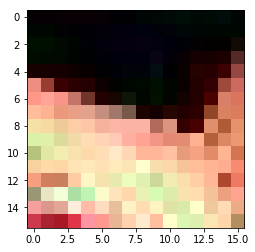

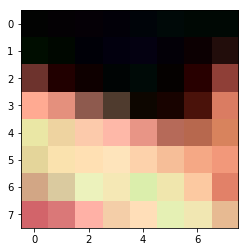

In [7]:
temp_index = np.random.randint(x_train.shape[0]) #  5429
# print(np.array(np.round(x_train[temp_index] * 255), dtype=np.uint8))
plt.imshow(np.array(np.round(x_train[temp_index] * 255), dtype=np.uint8))
plt.show()
plt.imshow(np.array(np.round(y_train[temp_index] * 255), dtype=np.uint8))
plt.show()

In [8]:
input_shape = (patch_size, patch_size, nb_channels)
input_img = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = MaxPool2D((2, 2), padding="same")(x)
x = MaxPool2D((2, 2), padding="same")(x)
encoded = MaxPool2D((2, 2), padding="same")(x)


x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation="relu", padding="same")(x)  # 32
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0     

In [12]:
image_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=False, fill_mode="nearest")

In [13]:
base_dir

'/home/niaki/Code/ImageNet/tiny-imagenet-200'

In [14]:
import wandb
from wandb.keras import WandbCallback
# os.environ['WANDB_MODE'] = 'dryrun'

In [15]:
wandb.init(
  project="patch-desc-ae",
  config={
    "augmentation": True,
    "elus": False,
    "downsampling_output": True,
    "optimizer": "adadelta", 
    "loss": "binary_crossentropy",
    "epochs": 50 }
)

wandb: Currently logged in as: nimpy (use `wandb login --relogin` to force relogin)


In [18]:
model_version = 'patch_desc_ae_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '16_alex_3conv3mp_2020_augm_relu_dwnsmpl'

os.system('mkdir ' + base_dir + '/weights_' + model_version)
print(base_dir + '/weights_' + model_version)

checkpointer = ModelCheckpoint(base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = autoencoder.fit(image_datagen.flow(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=50,
                validation_data=image_datagen.flow(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[WandbCallback(data_type="image", predictions=1)]  # checkpointer,
                )
autoencoder.save(base_dir + '/' + model_version + '.h5')

# autoencoder = load_model(base_dir + '/' + model_version + '.h5')

/home/niaki/Code/ImageNet/tiny-imagenet-200/weights_patch_desc_ae_20201022_17321416_alex_3conv3mp_2020_augm_relu_dwnsmpl
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 157086 steps, validate for 3932 steps
Epoch 1/50
  4905/157086 [..............................] - ETA: 26:20 - loss: 0.5594WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 7854300 batches). You may need to use the repeat() function when building your dataset.


  4906/157086 [..............................] - ETA: 26:52 - loss: 0.5523WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 7854300 batches). You may need to use the repeat() function when building your dataset.


  4909/157086 [..............................] - ETA: 26:46 - loss: 0.5501

In [19]:
wandb.save("patch_desc_ae.h5")

[]

In [20]:
run.finish()

NameError: name 'run' is not defined

In [23]:
history_callback.history  # why is it not lookint at val_loss? this could also explain why the checkpointer didn't see the validation data

{'loss': [0.6260780895730567,
  0.6060252179512783,
  0.5951909043093382,
  0.588207898284687,
  0.5833361623148873,
  0.5799492780454653,
  0.5769948917999261,
  0.5743361962744195,
  0.5720426948748691,
  0.5698638599777025,
  0.5676000748724821,
  0.5657318284355146,
  0.5641393776841065,
  0.5627947944526468,
  0.5617694119784642,
  0.5608027577650637,
  0.5600350316976609,
  0.5593533768477567,
  0.5587979410897435,
  0.5582050857955804,
  0.5576595787509168,
  0.5571195382178122,
  0.5566236612007337,
  0.5562273534259203,
  0.5558319495437104,
  0.5555073794478311,
  0.5550484862207733,
  0.5547436577936862,
  0.5544176297240138,
  0.5541249228143352,
  0.5538740699875232,
  0.5535941227033367,
  0.5533041276490459,
  0.5530735796840777,
  0.5528197375556622,
  0.5525572038842139,
  0.5523434904168886,
  0.5521194740207648,
  0.5519301754113966,
  0.5517560552052996,
  0.5515187149046759,
  0.5513685217808938,
  0.5511926709600107,
  0.5510058692489587,
  0.5509256292565424,
  0

In [ ]:
# didn't execute from here onward

In [1]:
images_directory = base_dir + '/tiny_test16/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        x = img_to_array(img)
        
        x = np.expand_dims(x, axis=0)
        images.append(x)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images /= 255
predictions = autoencoder.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1, interpolation='nearest')
    plt.show()
    
    pred_1 = predictions[i].reshape(input_shape)
    plt.imshow(pred_1, interpolation='nearest')
    plt.show()
    
    print("next")


NameError: name 'base_dir' is not defined

In [13]:
encoder = Model(input_img, encoded)
for layer in encoder.layers:
    encoder.get_layer(layer.name).set_weights(autoencoder.get_layer(layer.name).get_weights())
encoder.summary()

encoder.save(base_dir + '/encoder' + model_version + '.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 32)          0         
Total para

In [19]:
code_shape = (8, 2, 2)

images_directory = base_dir + '/tiny_test16/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
#     if counter > 100:
#         break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images.append(x)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2]) #patch_size, patch_size, 3
images /= 255
predictions = encoder.predict_on_batch(np.array(images))
# print("predictions: ")

# for i, im1 in enumerate(images):
#     im_1 = im1.reshape(input_shape)
#     plt.imshow(im_1, interpolation='nearest')
#     plt.show()
    
#     pred_1 = predictions[i].reshape(code_shape)
#     plt.imshow(pred_1, interpolation='nearest')
#     plt.show()
    
#     print("next")